In [1]:
from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor
from cities.utils.data_loader import db_connection
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    start = time.time()

    result = predictor.predict_cumulative(
        conn,
        intervention={
            "radius_blue": 350,
            "limit_blue": 0,
            "radius_yellow_line": 1320,
            "radius_yellow_stop": 2640,
            "limit_yellow": 0.5,
            "reform_year": 2015,
        },
    )
    end = time.time()
    print("Time elapsed:", end - start)

print(result.keys())

/home/rafal/miniconda3/envs/polis-dev/lib/python3.10/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_fil

Time elapsed: 1.233762264251709
dict_keys(['obs_cumsums', 'f_cumsums', 'cf_cumsums', 'limit_intervention', 'census_tracts', 'housing_units_factual', 'housing_units_counterfactual'])


In [3]:
print(predictor.data['continuous'].keys())

dict_keys(['downtown_overlap', 'median_value', 'median_distance', 'housing_units_original', 'total_value', 'housing_units', 'segregation_original', 'white_original', 'mean_limit_original', 'parcel_sqm', 'university_overlap', 'income'])


In [4]:
print(result['limit_intervention'])

tensor([1., 1., 1.,  ..., 0., 0., 0.])


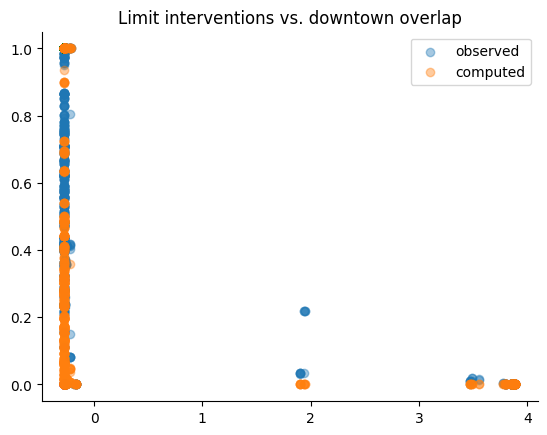

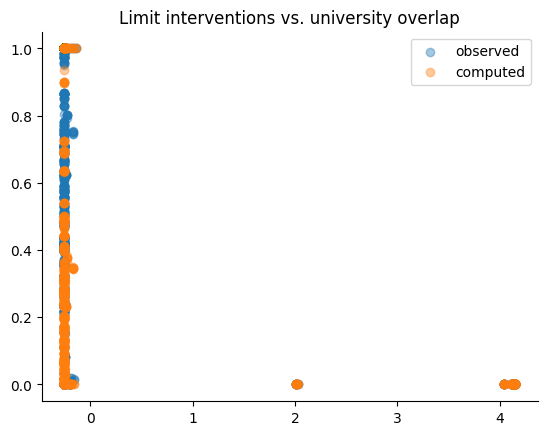

In [5]:
plt.scatter(predictor.data['continuous']['downtown_overlap'], predictor.data['continuous']['mean_limit_original'], 
            label='observed', alpha = .4)
plt.scatter(predictor.data['continuous']['downtown_overlap'], result['limit_intervention'], label='computed', alpha = .4)
plt.legend()
sns.despine()
plt.title('Limit interventions vs. downtown overlap')
plt.show()

plt.scatter(predictor.data['continuous']['university_overlap'], predictor.data['continuous']['mean_limit_original'], label='observed', alpha = .4)
plt.scatter(predictor.data['continuous']['university_overlap'], result['limit_intervention'], label='computed', alpha = .4)
plt.legend()
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()



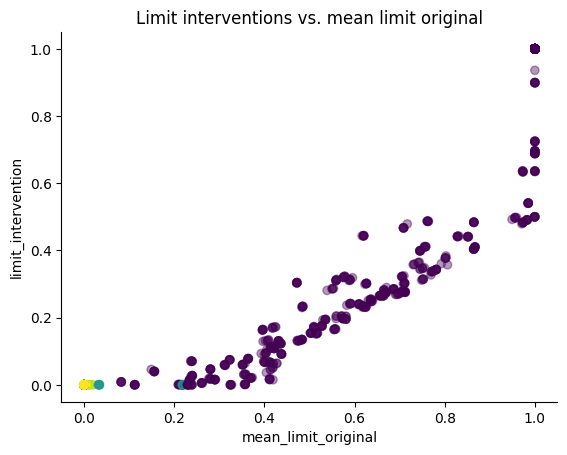

tensor(38)

In [6]:
# scatter limit_intervention vs. mean_limit_original
plt.scatter(predictor.data['continuous']['mean_limit_original'],
             result['limit_intervention'], alpha = .4,
            c = predictor.data['continuous']['downtown_overlap'])
plt.xlabel('mean_limit_original')
plt.ylabel('limit_intervention')
sns.despine()
plt.title('Limit interventions vs. mean limit original')
plt.show()
()
((predictor.data['continuous']['mean_limit_original'] >.99).int() * (result['limit_intervention'] < .99).int()).sum()

# this still doesn't seem like the factual setting


In [7]:
result['obs_cumsums'].keys()

matching_keys = [key for key in result['obs_cumsums'].keys() if '77' in str(key)]

print(matching_keys)


[tensor(27053007700)]


torch.Size([10])


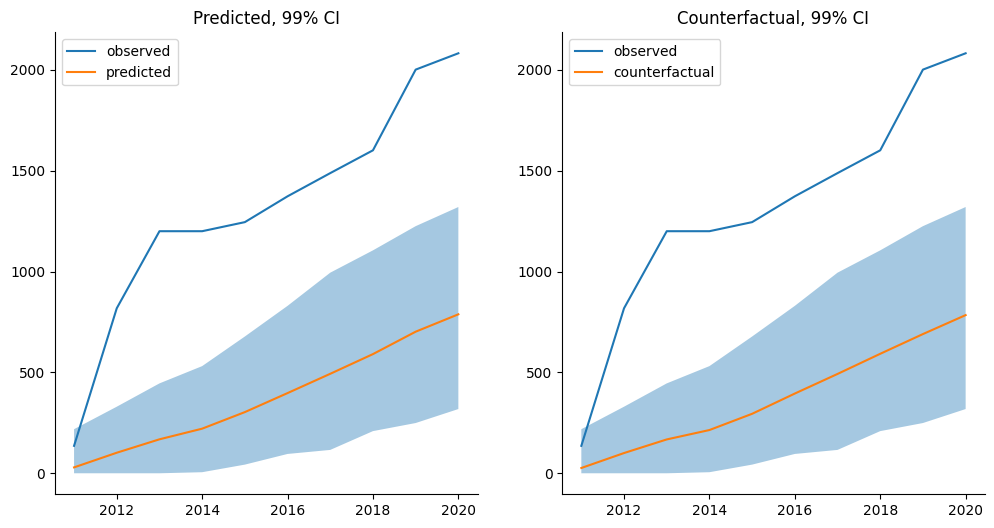

In [8]:
def plot_pred_timelines(key, result):
    
    obs = result['obs_cumsums'][key]
    quantiles = torch.tensor([0.005, 0.5, 0.995])

    print(obs.shape)
    f_mean_dif = (result['f_cumsums'][key] - obs.unsqueeze(1))
    cf_mean_dif = (result['cf_cumsums'][key] - obs.unsqueeze(1))


    f_summaries = result['f_cumsums'][key].quantile(quantiles, dim=1)
    cf_summaries = result['cf_cumsums'][key].quantile(quantiles, dim=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(predictor.years.unique(), obs, label='observed')
    ax1.plot(predictor.years.unique(), f_summaries[1,], label='predicted')
    ax1.fill_between(predictor.years.unique(), f_summaries[0,], f_summaries[2,], 
                    alpha=0.4)
    ax1.legend()
    ax1.set_title('Predicted, 99% CI') 
    sns.despine(ax=ax1)



    ax2.plot(predictor.years.unique(), obs, label='observed')
    ax2.plot(predictor.years.unique(), cf_summaries[1,], label='counterfactual')
    ax2.fill_between(predictor.years.unique(), f_summaries[0,], f_summaries[2,], 
                    alpha=0.4)
    ax2.legend()
    ax2.set_title('Counterfactual, 99% CI')
    sns.despine(ax=ax2)
    plt.show()


plot_pred_timelines(matching_keys[0], result)


[tensor(27053104900)]
torch.Size([10])


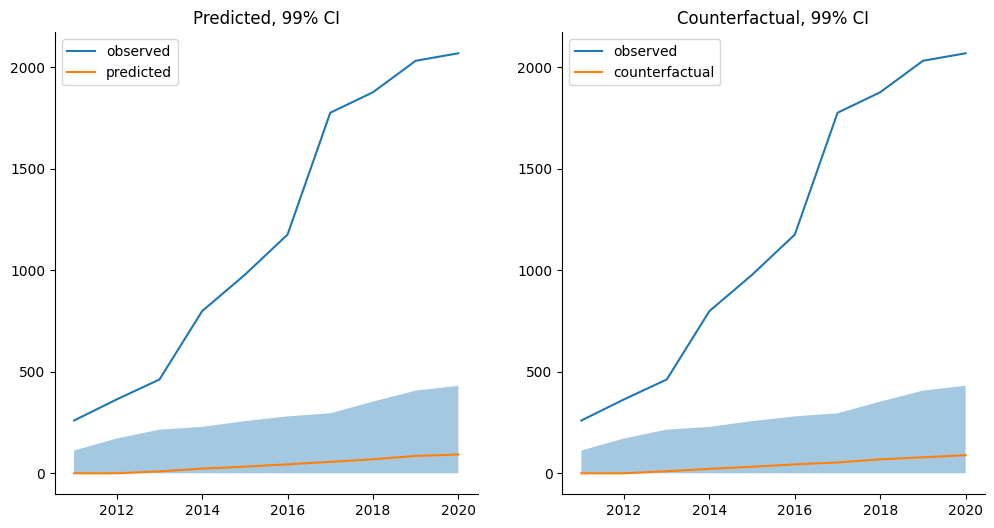

In [9]:
result['obs_cumsums'].keys()

matching_keys = [key for key in result['obs_cumsums'].keys() if '1049' in str(key)]

print(matching_keys)

plot_pred_timelines(matching_keys[0], result)

[tensor(27053105201)]
torch.Size([10])


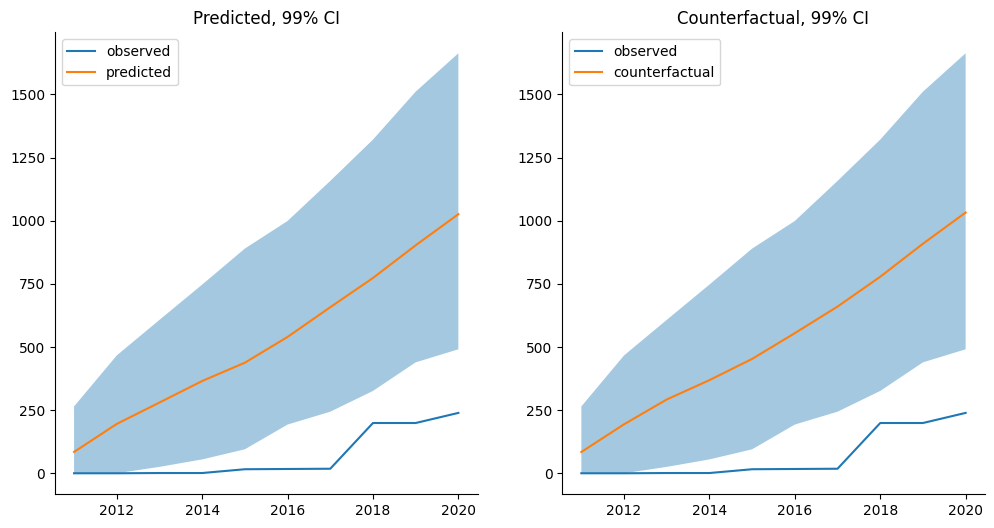

In [10]:
result['obs_cumsums'].keys()

matching_keys = [key for key in result['obs_cumsums'].keys() if '105201' in str(key)]

print(matching_keys)

plot_pred_timelines(matching_keys[0], result)

[tensor(27053104900)]
torch.Size([10])


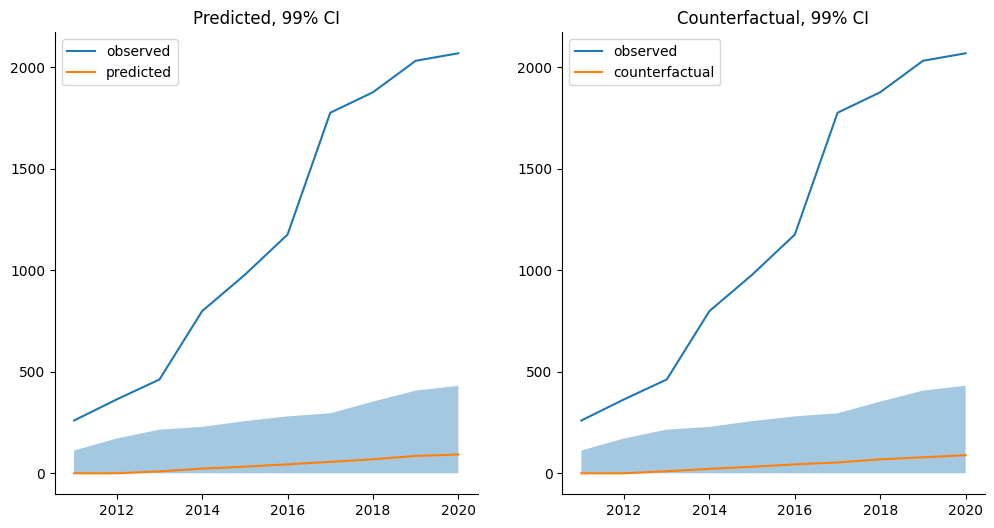

In [11]:
result['obs_cumsums'].keys()

matching_keys = [key for key in result['obs_cumsums'].keys() if '104900' in str(key)]

print(matching_keys)

plot_pred_timelines(matching_keys[0], result)